# Vertex AI: Qwik Start

## Learning objectives

* Train a TensorFlow model locally in a **Vertex Notebook**.
* Create a **managed Tabular dataset** artifact for experiment tracking.
* Containerize your training code and push it **Google Cloud Container Registry**.
* Run a **Vertex AI custom training job** with your custom model container.
* Use **Vertex TensorBoard** to monitor model performance during training.
* Deploy your trained model to a **Vertex Prediction Endpoint** for serving predictions.
* Request an online prediction and see the response.

## Introduction: customer lifetime value (CLV) prediction with BigQuery and TensorFlow on Vertex AI

In this lab, you will use BigQuery and Vertex AI to train and deploy a custom TensorFlow Regressor model to predict customer lifetime value. 

CLV is a customer's past value plus their predicted future value. Predictive CLV is to calculate how much monetary value a user will bring to the business in a given future time range. By knowing CLTV, we can develop positive ROI strategies and make decisions about how much money to invest in acquiring new customers and retaining existing ones.

## Predictive CLV: how much monetary value an existing customer will bring to the business in the future

Your task is to predict the future value for existing customers based on their known transaction history.

![CLV](./images/clv-rfm.svg "Customer Lifetime Value")

* **Recency**: The time between the last purchase and today, represented by the distance between the rightmost circle and the vertical dotted line that's labeled "Now".
* **Frequency**: The time between purchases, represented by the distance between the circles on a single line.
* **Monetary**: The amount of money spent on each purchase, represented by the size of the circle. This amount could be the average order value or the quantity of products that the customer ordered.

Once your ML model is a success, you can use the results to identify the category of customers more likely to spend money than the others, & make them respond to your offers and discounts with a greater frequency. These customers, with higher loyalty, are your main marketing target. This means retailers can effectively run campaigns based on the predictive lifetime value of any given customer.

By using the approaches described in this series to predict your customers' value, you can prioritize your next actions, such as the following:

* Decide how much to invest in advertising.
* Decide which customers to target with advertising.
* Plan how to move customers from one segment to another.

## Setup

### Define constants

In [2]:
# Add installed depedencies to Python PATH variable.
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin


In [3]:
# Retrieve and set PROJECT_ID and REGION environment variables.
PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
REGION = 'us-central1'

In [4]:
# Create Google Cloud Storage bucket for artifact storage.
BUCKET_NAME = f"gs://{PROJECT_ID}-bucket"
print(BUCKET_NAME)

gs://dougkelly-vertex-demos-bucket


In [ ]:
MODEL_NAME = "online-retail-clv"

### Import libraries

In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt

from google.cloud import aiplatform

In [6]:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

## Exploratory data analysis (EDA) in BigQuery

![CLV](./images/clv-data-splits.svg "Customer Lifetime Value")

### Q: Recency

### Q: Frequency

### Q: Monetary

### Establish a simple model performance baseline

In [7]:
%%bigquery

WITH
  day_intervals AS (
  SELECT
      customer_id,
      DATE_DIFF(DATE('2011-12-01'), DATE('2011-09-01'), DAY) AS target_days,
      DATE_DIFF(DATE('2011-09-01'), MIN(order_date), DAY) AS feature_days,
  FROM
    `dougkelly-vertex-demos.online_retail.online_retail_clv_clean`
  GROUP BY
      customer_id
  ),
    
  predicted_clv AS (
  SELECT
      customer_id,
      AVG(avg_purchase_revenue) * (COUNT(n_purchases) * (1 + SAFE_DIVIDE(COUNT(target_days),COUNT(feature_days)))) AS predicted_monetary_value_3M,
      SUM(target_monetary_value_3M) AS target_monetary_value_3M
  FROM
    `dougkelly-vertex-demos.online_retail.online_retail_clv_ml`
  LEFT JOIN day_intervals USING(customer_id)
  GROUP BY
      customer_id
  )

SELECT
  ROUND(AVG(ABS(predicted_monetary_value_3M - target_monetary_value_3M)), 2) AS MAE,
  ROUND(AVG(POW(predicted_monetary_value_3M - target_monetary_value_3M, 2)), 2) AS MSE,
  ROUND(SQRT(AVG(POW(predicted_monetary_value_3M - target_monetary_value_3M, 2))), 2) AS RMSE
FROM
  predicted_clv

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.51s/rows]


,MAE,MSE,RMSE
0,1762.06,81502420.93,9027.87


In [8]:
%%bigquery baseline

WITH
  day_intervals AS (
  SELECT
      customer_id,
      DATE_DIFF(DATE('2011-12-01'), DATE('2011-09-01'), DAY) AS target_days,
      DATE_DIFF(DATE('2011-09-01'), MIN(order_date), DAY) AS feature_days,
  FROM
    `dougkelly-vertex-demos.online_retail.online_retail_clv_clean`
  GROUP BY
      customer_id
  ),
    
  predicted_clv AS (
  SELECT
      customer_id,
      AVG(avg_purchase_revenue) * (COUNT(n_purchases) * (1 + SAFE_DIVIDE(COUNT(target_days),COUNT(feature_days)))) AS predicted_monetary_value_3M,
      SUM(target_monetary_value_3M) AS target_monetary_value_3M
  FROM
    `dougkelly-vertex-demos.online_retail.online_retail_clv_ml`
  INNER JOIN day_intervals USING(customer_id)
  GROUP BY
      customer_id
  )

SELECT
 *
FROM
  predicted_clv

Downloading: 100%|██████████| 3324/3324 [00:01<00:00, 1843.05rows/s]


In [9]:
baseline.head()

,customer_id,predicted_monetary_value_3M,target_monetary_value_3M
0,14420.0,775.04,387.52
1,13099.0,414.72,207.36
2,12436.0,1018.02,509.01
3,13276.0,274.76,590.93
4,12739.0,1951.08,1013.04


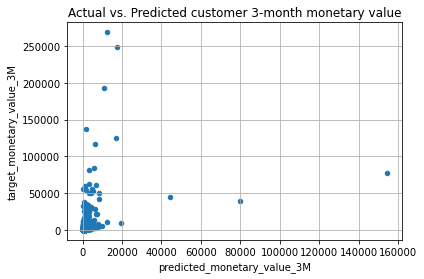

In [10]:
baseline.plot(kind='scatter',
              x='predicted_monetary_value_3M', 
              y='target_monetary_value_3M',
             title='Actual vs. Predicted customer 3-month monetary value',
             grid=True);

In [30]:
%%bigquery

SELECT data_split, COUNT(*)
FROM dougkelly-vertex-demos.online_retail.online_retail_clv_ml
GROUP BY data_split

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.26rows/s]


,data_split,f0_
0,TRAIN,2638
1,TEST,339
2,VALIDATE,353


## Train a TensorFlow model locally

In [ ]:
NUMERIC_FEATURES = [
    "customer_id",
    "n_purchases",
    "avg_purchase_size",
    "avg_purchase_revenue",
    "customer_age",
    "days_since_last_purchase",
    "target_monetary_value_3M",
]

CATEGORICAL_FEATURES = [
    "customer_country"
]

LABEL = "target_monetary_value_3M"

## Create a managed Tabular dataset from BigQuery

In [87]:
ds = aiplatform.TabularDataset.create(display_name="online-retail-clv", bq_source=f"bq://{PROJECT_ID}.online_retail.online_retail_clv_ml")

ds.name

INFO:google.cloud.aiplatform.datasets.dataset:Creating TabularDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TabularDataset backing LRO: projects/617979904441/locations/us-central1/datasets/8346058514912772096/operations/177987018159030272
INFO:google.cloud.aiplatform.datasets.dataset:TabularDataset created. Resource name: projects/617979904441/locations/us-central1/datasets/8346058514912772096
INFO:google.cloud.aiplatform.datasets.dataset:To use this TabularDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TabularDataset('projects/617979904441/locations/us-central1/datasets/8346058514912772096')


'8346058514912772096'

## Containerize your model training code and push it Google Container Registry

In [ ]:
Containerizing your model training 

### Create Cloudbuild YAML

In [11]:
cloudbuild_yaml = """steps:
- name: 'gcr.io/cloud-builders/docker'
  args: [ 'build', '-t', 'gcr.io/{PROJECT_ID}/online-retail-clv', '.' ]
images: ['gcr.io/{PROJECT_ID}/online-retail-clv']""".format(
    PROJECT_ID=PROJECT_ID
)

with open(f"trainer/cloudbuild.yaml", "w") as fp:
    fp.write(cloudbuild_yaml)

### Create Dockerfile

In [33]:
%%writefile trainer/Dockerfile
# Specifies base image and tag.
# https://cloud.google.com/vertex-ai/docs/training/pre-built-containers
FROM gcr.io/deeplearning-platform-release/tf2-cpu.2-3
WORKDIR /root

COPY requirements.txt .
# Installs additional packages.
RUN pip3 install -U -r requirements.txt

# Copies the trainer code to the docker image.
COPY task.py /root/task.py

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python3", "task.py"]

Overwriting trainer/Dockerfile


### Write training script

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--model-dir', dest='model_dir',
                    default=os.getenv('AIP_MODEL_DIR'), type=str, help='Model dir.')
parser.add_argument('--data-format', dest='data-format',
                    default=os.getenv('AIP_DATA_FORMAT'), type=str, help="Tabular data format. Either 'csv' or 'bigquery'")
parser.add_argument('--training-data-uri', dest='training-data-uri',
                    default=os.getenv('AIP_TRAINING_DATA_URI'), type=str, help='Model dir.')
parser.add_argument('--validation-data-uri', dest='validation-data-uri',
                    default=os.getenv('AIP_VALIDATION_URI'), type=str, help='Model dir.')
parser.add_argument('--test-data-uri', dest='test-data-uri',
                    default=os.getenv('AIP_TEST_URI'), type=str, help='Model dir.')

parser.add_argument('--learning-rate', dest='learning-rate', default=0.001, type=float, help='Learning rate.')
parser.add_argument('--epochs', dest='epochs', default=20, type=int, help='Number of epochs.')
parser.add_argument('--steps', dest='steps', default=100, type=int, help='Number of steps per epoch.')
args = parser.parse_args()

In [124]:
%%writefile trainer/task.py

import os
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession

# Model training constants.
# Virtual epochs design pattern:
# https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730
N_TRAIN_EXAMPLES = 2638
N_DEV_EXAMPLES = 353
STOP_POINT = 2.0
TOTAL_TRAIN_EXAMPLES = int(STOP_POINT * N_TRAIN_EXAMPLES)
BATCH_SIZE = 16
N_CHECKPOINTS = 2
STEPS_PER_EPOCH = (TOTAL_TRAIN_EXAMPLES // (BATCH_SIZE*N_CHECKPOINTS))


training_data_uri = os.environ["AIP_TRAINING_DATA_URI"]
validation_data_uri = os.environ["AIP_VALIDATION_DATA_URI"]
test_data_uri = os.environ["AIP_TEST_DATA_URI"]
data_format = os.environ["AIP_DATA_FORMAT"]

NUMERIC_FEATURES = [
    "customer_id",
    "n_purchases",
    "avg_purchase_size",
    "avg_purchase_revenue",
    "customer_age",
    "days_since_last_purchase",
    "target_monetary_value_3M",
]

CATEGORICAL_FEATURES = [
    "customer_country"
]

LABEL = "target_monetary_value_3M"


def caip_uri_to_fields(uri):
    uri = uri[5:]
    project, dataset, table = uri.split('.')
    return project, dataset, table


def features_and_labels(row_data):
    label = row_data.pop(LABEL)
    features = row_data
    return features, label


def read_bigquery(project, dataset, table):
    tensorflow_io_bigquery_client = BigQueryClient()
    read_session = tensorflow_io_bigquery_client.read_session(
      parent="projects/" + project,
      project_id=project, 
      dataset_id=dataset,
      table_id=table,
      selected_fields=NUMERIC_FEATURES + [LABEL],
      output_types=[dtypes.float64] * 7 + [dtypes.string],
      requested_streams=2)
    dataset = read_session.parallel_read_rows()
    transformed_ds = dataset.map(features_and_labels)
    return transformed_ds

BATCH_SIZE = 16

training_ds = read_bigquery(*caip_uri_to_fields(training_data_uri)).prefetch(1).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE)
eval_ds = read_bigquery(*caip_uri_to_fields(validation_data_uri)).prefetch(1).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE)
test_ds = read_bigquery(*caip_uri_to_fields(test_data_uri)).prefetch(1).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE)


feature_columns = {
    feature: tf.feature_column.numeric_column(feature)
    for feature in NUMERIC_FEATURES
}


# Create a custom evalution metric.
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_model():
    """
    """
    model = tf.keras.Sequential([
        tf.keras.layers.DenseFeatures(feature_columns.values()),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
#         log_dir=os.environ['AIP_TENSORBOARD_LOG_DIR'],
        log_dir=os.environ["AIP_MODEL_DIR"] + '/tensorboard-logs',
        histogram_freq=1)
    
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(patience=2)
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.environ["AIP_MODEL_DIR"] + '/checkpoints',
        save_weights_only=True,
        monitor='val_loss',
        mode='min')    
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  callbacks=[[tensorboard_callback, 
                              earlystopping_callback,
                              checkpoint_callback]],
                  metrics=[['mae', 'mse', rmse]])
    
    return model

model = build_model()

model.fit(training_ds,
          validation_data=eval_ds,
          steps_per_epoch=STEPS_PER_EPOCH,
          epochs=N_CHECKPOINTS,
          callbacks=[tensorboard_callback])

print(model.evaluate(test_ds))

# rankdir='LR' is used to make the graph horizontal.
# tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

tf.saved_model.save(model, os.environ["AIP_MODEL_DIR"])

Overwriting trainer/task.py


### Build and test container locally

In [26]:
%cd ./trainer

/home/jupyter/training-data-analyst/self-paced-labs/vertex-ai/vertex-ai-qwikstart/trainer


In [78]:
IMAGE_URI=f'gcr.io/{PROJECT_ID}/online-retail-clv'

In [28]:
!docker build ./ -t $IMAGE_URI

Sending build context to Docker daemon  15.36kB
Step 1/6 : FROM gcr.io/deeplearning-platform-release/tf2-cpu.2-3
 ---> ba7602e939e1
Step 2/6 : WORKDIR /root
 ---> Using cache
 ---> c770d95c077c
Step 3/6 : COPY requirements.txt .
 ---> Using cache
 ---> e30a0d135098
Step 4/6 : RUN pip3 install -U -r requirements.txt
 ---> Using cache
 ---> feca7418e039
Step 5/6 : COPY task.py /root/task.py
 ---> Using cache
 ---> 78faab8610af
Step 6/6 : ENTRYPOINT ["python3", "task.py"]
 ---> Using cache
 ---> 8d71b29f452e
Successfully built 8d71b29f452e
Successfully tagged gcr.io/dougkelly-vertex-demos/online-retail-clv:latest


In [29]:
!docker run $IMAGE_URI

2021-07-11 17:05:10.957606: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2021-07-11 17:05:10.958107: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
Traceback (most recent call last):
  File "task.py", line 10, in <module>
    training_data_uri = os.environ["AIP_TRAINING_DATA_URI"]
  File "/opt/conda/lib/python3.7/os.py", line 681, in __getitem__
    raise KeyError(key) from None
KeyError: 'AIP_TRAINING_DATA_URI'


### Build and submit container to Google Cloud Container Registry

In [125]:
!gcloud builds submit --timeout=15m --config trainer/cloudbuild.yaml trainer

Creating temporary tarball archive of 9 file(s) totalling 7.8 KiB before compression.
Uploading tarball of [trainer] to [gs://dougkelly-vertex-demos_cloudbuild/source/1626037693.841638-bc07001adaa94128be77e2a4d4cb0fb1.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/dougkelly-vertex-demos/locations/global/builds/cc70622e-9829-4c17-ae2f-ad3f37a9eb85].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/cc70622e-9829-4c17-ae2f-ad3f37a9eb85?project=617979904441].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "cc70622e-9829-4c17-ae2f-ad3f37a9eb85"

FETCHSOURCE
Fetching storage object: gs://dougkelly-vertex-demos_cloudbuild/source/1626037693.841638-bc07001adaa94128be77e2a4d4cb0fb1.tgz#1626037694168394
Copying gs://dougkelly-vertex-demos_cloudbuild/source/1626037693.841638-bc07001adaa94128be77e2a4d4cb0fb1.tgz#1626037694168394...
/ [1 files][  2.4 KiB/  2.4 KiB]                                                


## Run a training job on Vertex AI

In [126]:
aiplatform.init(project=PROJECT_ID, staging_bucket=BUCKET_NAME)

In [ ]:
job = aiplatform.CustomContainerTrainingJob(
    display_name="online-retail-clv",
    container_uri=f"gcr.io/{PROJECT_ID}/online-retail-clv:latest",
    # from https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
    model_serving_container_image_uri="gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-3:latest",
)

model = job.run(
    ds,
    replica_count=1,
    model_display_name="online-retail-clv-3M",
    bigquery_destination=f"bq://{PROJECT_ID}",
    predefined_split_column_name="data_split"
)

INFO:google.cloud.aiplatform.training_jobs:Training Output directory:
gs://dougkelly-vertex-demos-bucket/aiplatform-custom-training-2021-07-11-21:15:11.619 
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4558966634898784256?project=617979904441
INFO:google.cloud.aiplatform.training_jobs:CustomContainerTrainingJob projects/617979904441/locations/us-central1/trainingPipelines/4558966634898784256 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:CustomContainerTrainingJob projects/617979904441/locations/us-central1/trainingPipelines/4558966634898784256 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:CustomContainerTrainingJob projects/617979904441/locations/us-central1/trainingPipelines/4558966634898784256 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:CustomContain

## Monitor model training performance with Vertex TensorBoard

In [76]:
TENSORBOARD_RESOURCE_NAME="projects/617979904441/locations/us-central1/tensorboards/6037391959838949376"

In [34]:
!gcloud beta ai tensorboards create \
--display-name=online-retail-clv --region=us-central1

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [8195309148552822784]...done.                            
Created Vertex AI Tensorboard: projects/617979904441/locations/us-central1/tensorboards/6037391959838949376.


In [79]:
# Fill in *all* the following env vars for your project
PROJECT_NAME={PROJECT_ID}
TENSORBOARD_RESOURCE_NAME={TENSORBOARD_RESOURCE_NAME}
GCS_BUCKET_NAME="$BUCKET_NAME-tensorboard-logs-${REGION}"
USER_SA_EMAIL="USER_SA_NAME@PROJECT_NAME.iam.gserviceaccount.com"
TRAINING_CONTAINER={IMAGE_URI}
REGION={REGION}

ENDPOINT="$REGION-aiplatform.googleapis.com"
INVOCATION_TIMESTAMP="$(date  +'%Y%m%d-%H%M%S')"
JOB_NAME="tensorboard-example-job-${INVOCATION_TIMESTAMP}"
BASE_OUTPUT_DIR="gs://$GCS_BUCKET_NAME/$JOB_NAME"

TypeError: unhashable type: 'set'

In [70]:
!curl \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
-X POST \
-d "{
'displayName':'$JOB_NAME',
'BigQueryDestination': 'bq://$PROJECT_ID', 
'CustomJobSpec':{
'workerPoolSpecs':[
     {
        'replicaCount': '1',
        'machineSpec': {
          'machineType': 'n1-standard-4',
        },
        'containerSpec': {
          'imageUri': '$TRAINING_CONTAINER',
        }
      }
],
'base_output_directory': {
'output_uri_prefix': '$BASE_OUTPUT_DIR',
 },
'serviceAccount': '$USER_SA_EMAIL',
'tensorboard':'$TENSORBOARD_RESOURCE_NAME',
}
    }" \
https://${ENDPOINT}/v1beta1/projects/${PROJECT_NAME}/locations/us-central1/customJobs

SyntaxError: invalid syntax (<ipython-input-70-618464b5fac8>, line 2)

## Deploy a model endpoint

In [ ]:
explain_params = aiplatform.explain.ExplanationParameters(
    {"sampled_shapley_attribution": {"path_count": 10}}
)

In [ ]:
endpoint = model.deploy(machine_type="n1-standard-2",
                        explanation_parameters=explain_params
                       )

## Get online prediction and explanation from deployed model

In [ ]:
explained_prediction = endpoint.explain([test_instance_dict])

In [ ]:
predictions = explained_prediction.predictions[0]
pd.DataFrame.from_dict(predictions).plot(kind='bar');

In [ ]:
attributions = response.explanations[0].attributions[0].feature_attributions
pd.DataFrame.from_dict(explained_prediction.explanations[0].attributions[0].feature_attributions, orient='index').plot(kind='barh');

## Next steps

In this lab, you utilized Google Cloud's BigQuery, TensorFlow, and Vertex AI services to predict customer lifetime value.

This lab demonstrated a simple way to predict customer 3-month CLV monetary value. Additional factors to consider when using CLV to inform interventions include customer acquisition costs and discount rates to arrive at the present value of future customer cash flows. 

## License

In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.